<a href="https://colab.research.google.com/github/Sebastien01/images_classification/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/image_scene/data/seg_train/seg_train'
test_path = '/content/drive/MyDrive/image_scene/data/seg_test/seg_test'
pred_path = '/content/drive/MyDrive/image_scene/data/seg_pred/'

IMG_SIZE = (160,160)
BATCH_SIZE = 32

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
train_dataset = image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical')

Found 13261 files belonging to 6 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(test_path,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  label_mode='categorical')

Found 2994 files belonging to 6 classes.


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
pred_dataset = image_dataset_from_directory(pred_path,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,label_mode='categorical')

Found 7301 files belonging to 1 classes.


In [ ]:
class_names = train_dataset.class_names

In [ ]:
def plot_class_distribution(dataset,ds_name):
  class_array = np.concatenate(list(dataset.map(lambda image,label: label).as_numpy_iterator()),axis=0)
  class_count = [class_array[:,i].sum() for i in range(class_array.shape[1])]
  sns.barplot(y=class_count,x=class_names)
  plt.title(f'{ds_name} distribution')

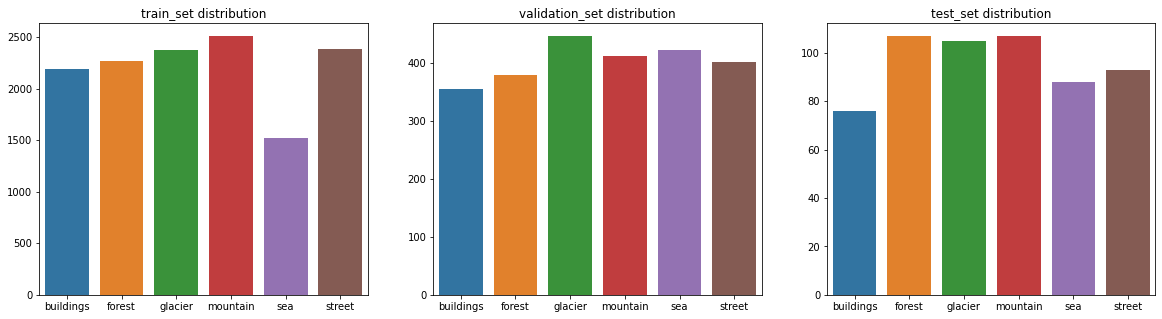

In [ ]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,3,1)
plot_class_distribution(train_dataset,'train_set')
ax = plt.subplot(1,3,2)
plot_class_distribution(validation_dataset,'validation_set')
ax = plt.subplot(1,3,3)
plot_class_distribution(test_dataset,'test_set')

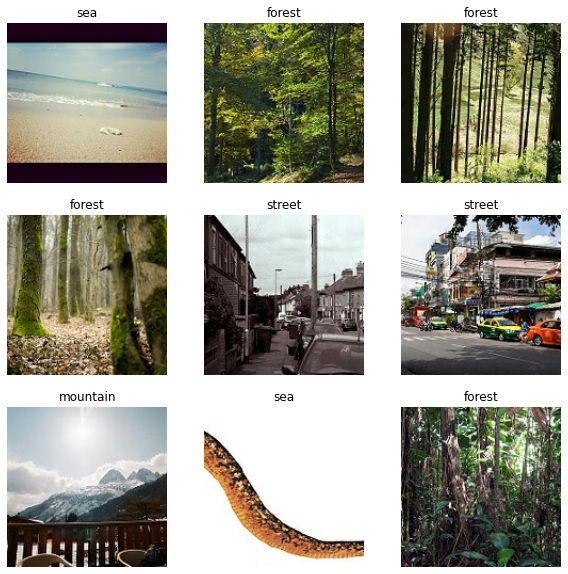

In [ ]:
images,labels = next(iter(validation_dataset))
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i].numpy().argmax()])
  plt.axis("off")

After a quick analysis of the datasets, we noticed that :
1. the `sea` class is under-represented 
2. Our datasets appear to be polluted by random mislabelled images 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
pred_dataset = pred_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [ ]:
# Create the base model from the pre-trained model xception
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(6,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0     

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_dataset)

18/18 [==============================] - 90s 3s/step - loss: 2.0470 - categorical_accuracy: 0.1215


In [ ]:
print('Baseline loss:', loss0)
print('Baseline accuracy:', accuracy0)

Baseline loss: 2.046964406967163
Baseline accuracy: 0.1215277761220932


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
415/415 [==============================] - 1839s 4s/step - loss: 1.1895 - categorical_accuracy: 0.6251 - val_loss: 0.7035 - val_categorical_accuracy: 0.8581
Epoch 2/10
415/415 [==============================] - 82s 195ms/step - loss: 0.6662 - categorical_accuracy: 0.8279 - val_loss: 0.5444 - val_categorical_accuracy: 0.8784
Epoch 3/10
415/415 [==============================] - 81s 195ms/step - loss: 0.5628 - categorical_accuracy: 0.8481 - val_loss: 0.4855 - val_categorical_accuracy: 0.8879
Epoch 4/10
415/415 [==============================] - 81s 195ms/step - loss: 0.5097 - categorical_accuracy: 0.8657 - val_loss: 0.4577 - val_categorical_accuracy: 0.8896
Epoch 5/10
415/415 [==============================] - 81s 194ms/step - loss: 0.4764 - categorical_accuracy: 0.8745 - val_loss: 0.4348 - val_categorical_accuracy: 0.8983
Epoch 6/10
415/415 [==============================] - 81s 194ms/step - loss: 0.4594 - categorical_accuracy: 0.8746 - val_loss: 0.4171 - val_categorical_accu

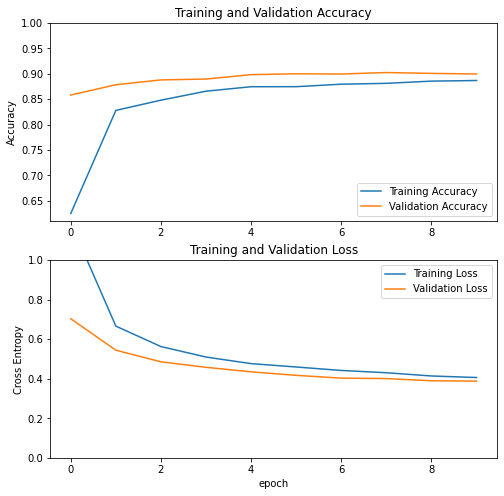

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_categorical_accuracy')

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es])

Epoch 10/20
415/415 [==============================] - 127s 288ms/step - loss: 0.3542 - categorical_accuracy: 0.9026 - val_loss: 0.3138 - val_categorical_accuracy: 0.9206
Epoch 11/20
415/415 [==============================] - 119s 285ms/step - loss: 0.3067 - categorical_accuracy: 0.9200 - val_loss: 0.2931 - val_categorical_accuracy: 0.9285
Epoch 12/20
415/415 [==============================] - 118s 284ms/step - loss: 0.2791 - categorical_accuracy: 0.9300 - val_loss: 0.2822 - val_categorical_accuracy: 0.9293
Epoch 13/20
415/415 [==============================] - 119s 285ms/step - loss: 0.2519 - categorical_accuracy: 0.9380 - val_loss: 0.2808 - val_categorical_accuracy: 0.9330
Epoch 14/20
415/415 [==============================] - 120s 287ms/step - loss: 0.2324 - categorical_accuracy: 0.9465 - val_loss: 0.2718 - val_categorical_accuracy: 0.9359
Epoch 15/20
415/415 [==============================] - 120s 288ms/step - loss: 0.2153 - categorical_accuracy: 0.9495 - val_loss: 0.2739 - val_cat

In [ ]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

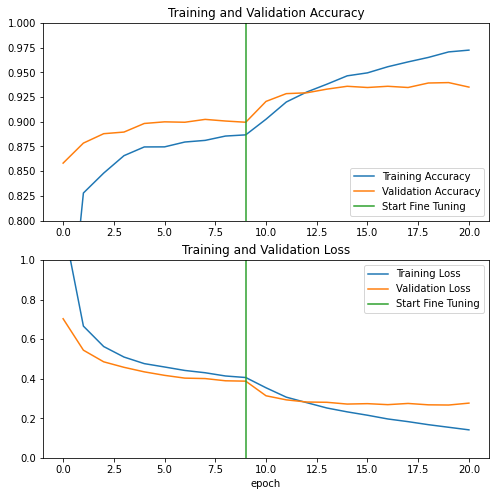

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

18/18 [==============================] - 4s 164ms/step - loss: 0.3155 - categorical_accuracy: 0.9167


In [ ]:
plt.figure(figsize=(10, 10))
for images in pred_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i].numpy().argmax()])
    #plt.axis("off")

NameError: ignored

In [ ]:
preprocess_input = tf.keras.applications.xception.preprocess_input
# Create the base model from the pre-trained model xception
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
resnet_base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')

In [ ]:
resnet_base_model.trainable = False

In [ ]:
resnet_base_model.summary()

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = resnet_base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1536)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(6,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1536)
(32, 6)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = resnet_base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
resnet_model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
history = resnet_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
415/415 [==============================] - 223s 505ms/step - loss: 0.7910 - categorical_accuracy: 0.7217 - val_loss: 0.4205 - val_categorical_accuracy: 0.8664
Epoch 2/10
415/415 [==============================] - 204s 489ms/step - loss: 0.3865 - categorical_accuracy: 0.8612 - val_loss: 0.3185 - val_categorical_accuracy: 0.8945
Epoch 3/10
415/415 [==============================] - 203s 487ms/step - loss: 0.3275 - categorical_accuracy: 0.8797 - val_loss: 0.2829 - val_categorical_accuracy: 0.9007
Epoch 4/10
415/415 [==============================] - 203s 487ms/step - loss: 0.2983 - categorical_accuracy: 0.8924 - val_loss: 0.2655 - val_categorical_accuracy: 0.9049
Epoch 5/10
415/415 [==============================] - 204s 491ms/step - loss: 0.2828 - categorical_accuracy: 0.8940 - val_loss: 0.2592 - val_categorical_accuracy: 0.9049
Epoch 6/10
415/415 [==============================] - 204s 490ms/step - loss: 0.2676 - categorical_accuracy: 0.9034 - val_loss: 0.2457 - val_categoric

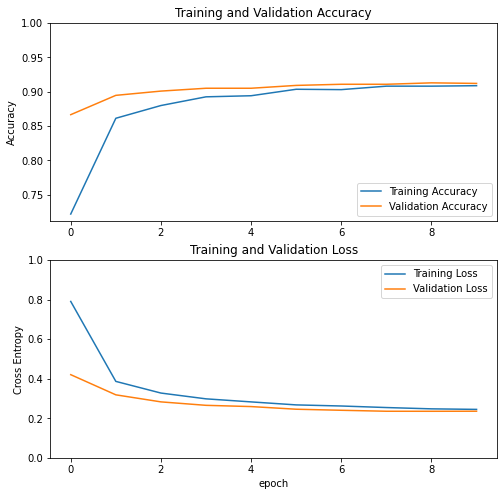

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
resnet_base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_base_model.layers))

Number of layers in the base model:  780


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 600

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_categorical_accuracy')

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = resnet_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es])

Epoch 10/20
415/415 [==============================] - 290s 655ms/step - loss: 0.2155 - categorical_accuracy: 0.9213 - val_loss: 0.1916 - val_categorical_accuracy: 0.9305
Epoch 11/20
415/415 [==============================] - 268s 643ms/step - loss: 0.1578 - categorical_accuracy: 0.9418 - val_loss: 0.2002 - val_categorical_accuracy: 0.9305
Epoch 12/20
415/415 [==============================] - 267s 641ms/step - loss: 0.1158 - categorical_accuracy: 0.9604 - val_loss: 0.2136 - val_categorical_accuracy: 0.9305
Epoch 13/20
415/415 [==============================] - 267s 641ms/step - loss: 0.0798 - categorical_accuracy: 0.9725 - val_loss: 0.2343 - val_categorical_accuracy: 0.9322
Epoch 14/20
415/415 [==============================] - 267s 641ms/step - loss: 0.0519 - categorical_accuracy: 0.9805 - val_loss: 0.2643 - val_categorical_accuracy: 0.9359
Epoch 15/20
415/415 [==============================] - 267s 641ms/step - loss: 0.0319 - categorical_accuracy: 0.9890 - val_loss: 0.4547 - val_cat

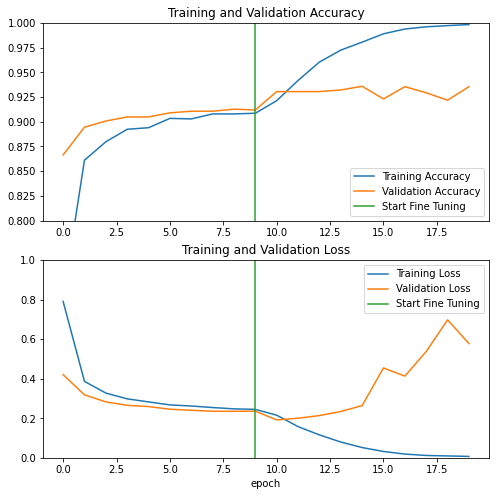

In [ ]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = resnet_model.evaluate(test_dataset)

18/18 [==============================] - 8s 416ms/step - loss: 0.2480 - categorical_accuracy: 0.9323


In [ ]:
from tensorflow.keras.models import save_model

In [ ]:
save_model(model,'/content/drive/MyDrive/image_scene/InceptionResNet')